# 1. Title & Introduction

# 🏥 InsureVision: A Deep Dive into Health Cross-Selling

**Author:** Gabriel Telles  
**Date:** `16/05/2025`  

---

> **Objective:**  
> - Perform a professional exploratory data analysis (EDA) of health insurance cross-sell behavior  
> - Build and evaluate a simple predictive model  
> - Showcase advanced, interactive visualizations  
> - Demonstrate code modularity and export the final model  

---


# 2. Imports & Configuration

In [1]:
# ─── Basic data handling ─────────────────────────────────────────────────────
import pandas as pd                # for data manipulation
import numpy as np                 # for numerical operations

# ─── Static visualization ───────────────────────────────────────────────────
import matplotlib.pyplot as plt    # core plotting library
import seaborn as sns              # statistical plotting built on matplotlib

# ─── Interactive visualization ──────────────────────────────────────────────
import plotly.express as px        # easy, high-level Plotly interface

# ─── Machine learning ───────────────────────────────────────────────────────
from sklearn.model_selection import train_test_split
from sklearn.preprocessing    import StandardScaler, OneHotEncoder
from sklearn.compose          import ColumnTransformer
from sklearn.pipeline         import Pipeline
from sklearn.linear_model     import LogisticRegression
from sklearn.metrics          import (
    classification_report,
    roc_auc_score,
    roc_curve,
    confusion_matrix
)

# ─── Model persistence ──────────────────────────────────────────────────────
import pickle

# ─── Global styling ─────────────────────────────────────────────────────────
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

# 3. Load the Data

In [2]:
# Load training data
df = pd.read_csv('../data/raw/train.csv')

In [3]:
df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


# 4. Dataset Overview

In [4]:
# Show dimensions
print(f"Dataset dimensions: {df.shape}")

Dataset dimensions: (381109, 12)


In [5]:
# Data types and non-null counts
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   Gender                381109 non-null  object 
 2   Age                   381109 non-null  int64  
 3   Driving_License       381109 non-null  int64  
 4   Region_Code           381109 non-null  float64
 5   Previously_Insured    381109 non-null  int64  
 6   Vehicle_Age           381109 non-null  object 
 7   Vehicle_Damage        381109 non-null  object 
 8   Annual_Premium        381109 non-null  float64
 9   Policy_Sales_Channel  381109 non-null  float64
 10  Vintage               381109 non-null  int64  
 11  Response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


In [6]:
# Descriptive statistics
display(df.describe(include='all').T)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,381109.0,NaN,NaN,NaN,190555.0,110016.836208,1.0,95278.0,190555.0,285832.0,381109.0
Gender,381109,2,Male,206089,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,381109.0,NaN,NaN,NaN,38.822584,15.511611,20.0,25.0,36.0,49.0,85.0
Driving_License,381109.0,NaN,NaN,NaN,0.997869,0.04611,0.0,1.0,1.0,1.0,1.0
Region_Code,381109.0,NaN,NaN,NaN,26.388807,13.229888,0.0,15.0,28.0,35.0,52.0
Previously_Insured,381109.0,NaN,NaN,NaN,0.45821,0.498251,0.0,0.0,0.0,1.0,1.0
Vehicle_Age,381109,3,1-2 Year,200316,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Vehicle_Damage,381109,2,Yes,192413,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Annual_Premium,381109.0,NaN,NaN,NaN,30564.389581,17213.155057,2630.0,24405.0,31669.0,39400.0,540165.0
Policy_Sales_Channel,381109.0,NaN,NaN,NaN,112.034295,54.203995,1.0,29.0,133.0,152.0,163.0


In [7]:
# Count missing values per column
missing_counts = df.isnull().sum()
print("\nMissing values per column:")
display(missing_counts[missing_counts > 0])


Missing values per column:


Series([], dtype: int64)

# 5. Exploratory Data Analysis

## 5.1 Missing Values & Duplicates

In [8]:
# Plot missing value counts (if any)
missing = df.isnull().sum().loc[lambda x: x>0]
if not missing.empty:
    sns.barplot(x=missing.values, y=missing.index)
    plt.title("Count of Missing Values by Feature")
    plt.show()
else:
    print("No missing values found.")

# Check for duplicate rows
print(f"Number of duplicate rows: {df.duplicated().sum()}")

No missing values found.
Number of duplicate rows: 0


## 5.2 Univariate Distributions

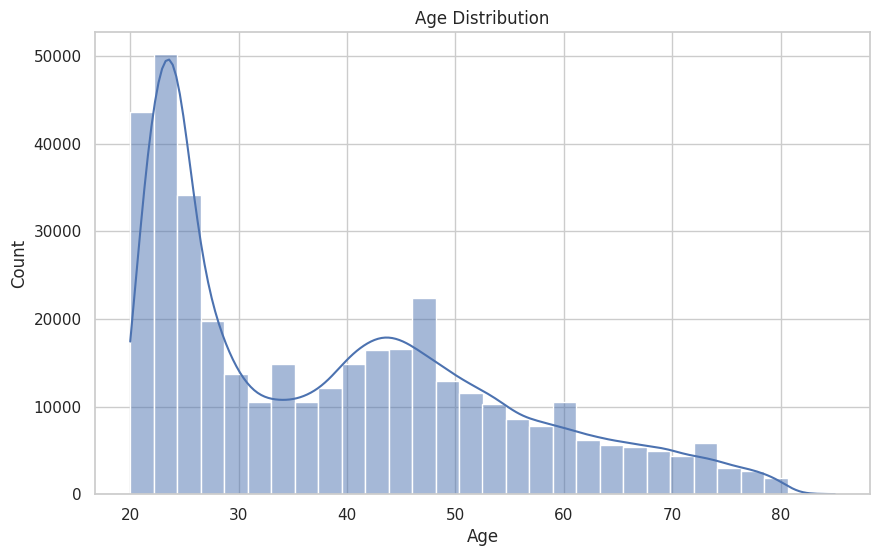

In [9]:
# Age distribution
sns.histplot(df["Age"], bins=30, kde=True)
plt.title("Age Distribution")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

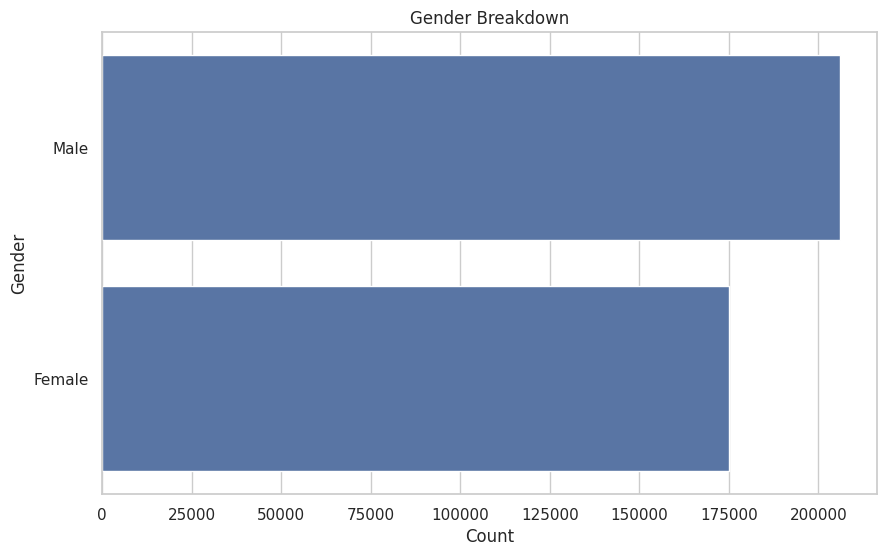

In [10]:
# Gender counts
sns.countplot(y="Gender", data=df)
plt.title("Gender Breakdown")
plt.xlabel("Count")
plt.ylabel("Gender")
plt.show()

## 5.3 Bivariate Analysis vs. Target

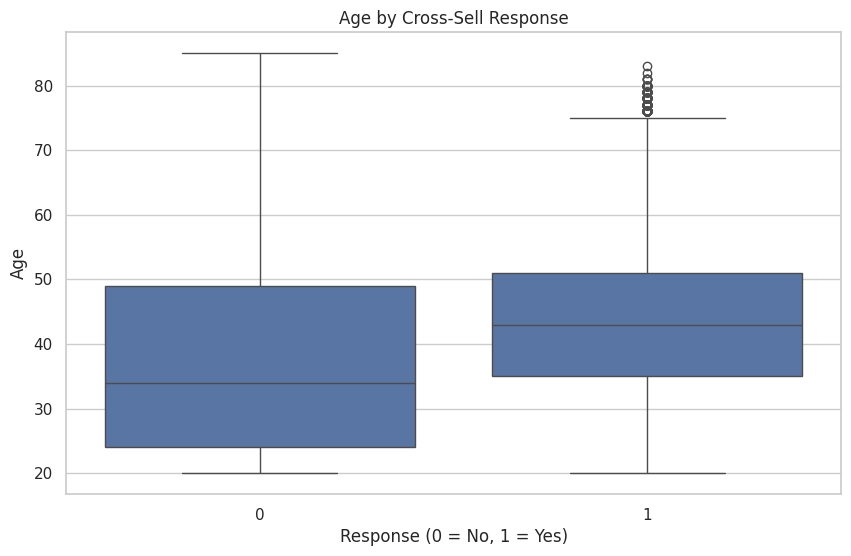

In [11]:
# Boxplot of Age by Response
sns.boxplot(x="Response", y="Age", data=df)
plt.title("Age by Cross-Sell Response")
plt.xlabel("Response (0 = No, 1 = Yes)")
plt.ylabel("Age")
plt.show()

# 6. Correlation Heatmap

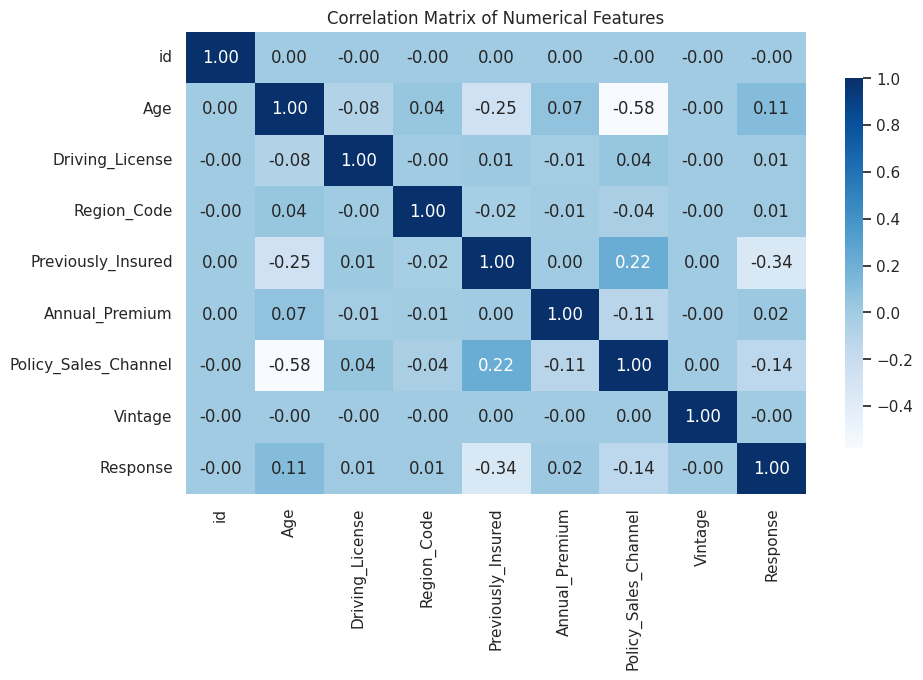

In [13]:
# Compute correlation matrix for numeric features
numeric_cols = df.select_dtypes(include=["int64","float64"]).columns
corr_matrix = df[numeric_cols].corr()

sns.heatmap(
    corr_matrix, annot=True, fmt=".2f",
    cmap="Blues", cbar_kws={"shrink": 0.8}
)
plt.title("Correlation Matrix of Numerical Features")
plt.show()

# 7. Feature Engineering

In [14]:
# Convert Gender to binary flag
df["Is_Male"] = (df["Gender"] == "Male").astype(int)

In [15]:
# One-hot encode Region_Code
region_dummies = pd.get_dummies(df["Region_Code"], prefix="Region")
df = pd.concat([df, region_dummies], axis=1)

In [16]:
# One-hot encode Region_Code
region_dummies = pd.get_dummies(df["Region_Code"], prefix="Region")
df = pd.concat([df, region_dummies], axis=1)

In [17]:
df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,...,Region_43.0,Region_44.0,Region_45.0,Region_46.0,Region_47.0,Region_48.0,Region_49.0,Region_50.0,Region_51.0,Region_52.0
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,...,False,False,False,False,False,False,False,False,False,False
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,...,False,False,False,False,False,False,False,False,False,False
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,...,False,False,False,False,False,False,False,False,False,False
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,...,False,False,False,False,False,False,False,False,False,False
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,...,False,False,False,False,False,False,False,False,False,False


# 8. Predictive Modeling

In [18]:
# Split features and target
X = df.drop("Response", axis=1)
y = df["Response"]

In [19]:
# Train/test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [20]:
# Define preprocessing for numeric and categorical
numeric_features     = ["Age", "Annual_Premium"]
categorical_features = [col for col in X.columns if col not in numeric_features]

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numeric_features),
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
])

In [22]:
# Build pipeline with logistic regression
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=1000))
])

In [24]:
# Train the model
pipeline.fit(X_train, y_train)

ValueError: Selected columns, ['id', 'Gender', 'Driving_License', 'Region_Code', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Policy_Sales_Channel', 'Vintage', 'Is_Male', 'Region_0.0', 'Region_1.0', 'Region_2.0', 'Region_3.0', 'Region_4.0', 'Region_5.0', 'Region_6.0', 'Region_7.0', 'Region_8.0', 'Region_9.0', 'Region_10.0', 'Region_11.0', 'Region_12.0', 'Region_13.0', 'Region_14.0', 'Region_15.0', 'Region_16.0', 'Region_17.0', 'Region_18.0', 'Region_19.0', 'Region_20.0', 'Region_21.0', 'Region_22.0', 'Region_23.0', 'Region_24.0', 'Region_25.0', 'Region_26.0', 'Region_27.0', 'Region_28.0', 'Region_29.0', 'Region_30.0', 'Region_31.0', 'Region_32.0', 'Region_33.0', 'Region_34.0', 'Region_35.0', 'Region_36.0', 'Region_37.0', 'Region_38.0', 'Region_39.0', 'Region_40.0', 'Region_41.0', 'Region_42.0', 'Region_43.0', 'Region_44.0', 'Region_45.0', 'Region_46.0', 'Region_47.0', 'Region_48.0', 'Region_49.0', 'Region_50.0', 'Region_51.0', 'Region_52.0', 'Region_0.0', 'Region_1.0', 'Region_2.0', 'Region_3.0', 'Region_4.0', 'Region_5.0', 'Region_6.0', 'Region_7.0', 'Region_8.0', 'Region_9.0', 'Region_10.0', 'Region_11.0', 'Region_12.0', 'Region_13.0', 'Region_14.0', 'Region_15.0', 'Region_16.0', 'Region_17.0', 'Region_18.0', 'Region_19.0', 'Region_20.0', 'Region_21.0', 'Region_22.0', 'Region_23.0', 'Region_24.0', 'Region_25.0', 'Region_26.0', 'Region_27.0', 'Region_28.0', 'Region_29.0', 'Region_30.0', 'Region_31.0', 'Region_32.0', 'Region_33.0', 'Region_34.0', 'Region_35.0', 'Region_36.0', 'Region_37.0', 'Region_38.0', 'Region_39.0', 'Region_40.0', 'Region_41.0', 'Region_42.0', 'Region_43.0', 'Region_44.0', 'Region_45.0', 'Region_46.0', 'Region_47.0', 'Region_48.0', 'Region_49.0', 'Region_50.0', 'Region_51.0', 'Region_52.0'], are not unique in dataframe